# Assignment: intro to corpus linguistis with Python

*Computational Linguistics -- Gianluca E. Lebani*

---

#### Student's name: Shamira Venturini

#### Student's ID: 882125

#### By submitting this notebook, you implicitly agree to the following code of conduct:

>My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).
>
>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.
>
>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

> **source**: from Coursera's [Honor Code](https://www.coursera.org/about/terms/honorcode)

---

In [46]:
import math
import collections
import nltk 
from nltk.corpus import reuters, gutenberg, brown
import csv
import random
import re
import matplotlib.pyplot as plt 

%matplotlib inline 

In [47]:
plt.rcParams['figure.figsize'] = (15, 10) 

---

### Question 1. (2 points)

Use Python to create an artificial collections of words whose distribution **does NOT follow the Zipf's law**. 

Plot the Zipf's curve to show the effectiveness of your strategy.


*Requirements*: 

- corpus size: approximately 100k tokens

- vocabulary size: at least 100 types

- your dataset DOES NOT need to be composed of grammatical and/or meaningful sentences

Corpus size: 104394
Vocabulary size: 352


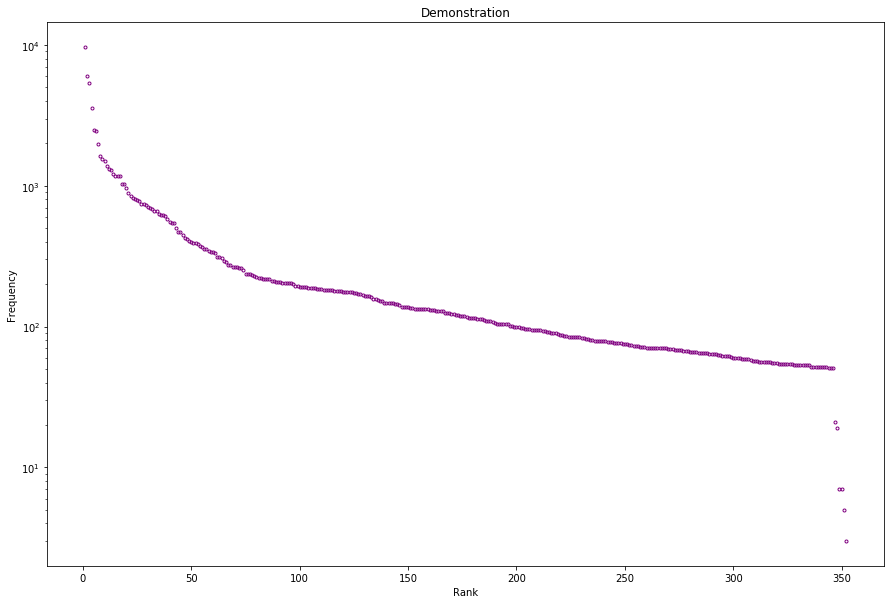

In [48]:
# your code here
random_words = random.sample(list(gutenberg.words()), 200000)
gutenberg_count = collections.Counter(random_words)

gutenberg_most = []
for word, fr in gutenberg_count.items():
    if word.isalnum() and fr > 50:
        gutenberg_most.append(word.lower())
        
artificial_corpus = []
for word in random_words:
    if word in gutenberg_most:
            artificial_corpus.append(word)
            
print("Corpus size:",len(artificial_corpus))
print("Vocabulary size:",len(set(artificial_corpus)))

y = [word for word in sorted(collections.Counter(artificial_corpus).values(), reverse = True)]
x = range(1, len(y) + 1)

plt.plot(x, y, ".", color = "purple", markerfacecolor = "None")
plt.yscale("log")

plt.title("Demonstration")
plt.ylabel("Frequency")
plt.xlabel("Rank")

plt.show()


---

### Question 2. (3 points)

Go through all the words in the following corpora from the NLTK:

- `nltk.corpus.brown`

- `nltk.corpus.gutenberg`

- `nltk.corpus.reuters`


For each corpus:

**(1)** calculate its corpus size, its vocabulary size and its number of hapax legomena. Print these statistics nicely formatted as follows:

```
corpus       corpus_size    vocabulary_size    hapax_legomena
brown               xxxx               xxxx              xxxx 
gutenberg           xxxx               xxxx              xxxx     
reuters             xxxx               xxxx              xxxx 
```

**(2)** count the frequency of its types in a case unsensitive way, sort the words by frequency (from the most frequent to the hapax legomena) and store the sorted (word, frequency) pairs in a file labelled `[corpus_name]_frequency_list.txt` formatted as follows (feel free to use the `csv` module or not):

```
the 90500
of 46573 
...
```

NOTE: the separator of the output file is intended to be a single whitespace (i.e. " ")

In [49]:
# your code here

for col_name in ["Corpus", "Corpus_size", "Vocabulary_size", "Hapax_Legomena"]:
    print("%15s"%col_name, end=" ")
    
print()
print() 

Reuters = [word for word in reuters.words() if re.search(r"[A-Za-z]", word)]
Gutenberg = [word for word in gutenberg.words() if re.search(r"[A-Za-z]", word)]
Brown = [word for word in brown.words() if re.search(r"[A-Za-z]", word)]

corpora = {"Reuters" : Reuters, "Gutenberg" : Gutenberg, "Brown" : Brown}

for key, value in corpora.items():
    print("%15s"%k, "%15d"%len(value),
          "%15d"%len(set(value)), 
          "%15d"%len(collections.Counter([word for word, freq in collections.Counter(value).items() if freq == 1])))



         Corpus     Corpus_size Vocabulary_size  Hapax_Legomena 

          Brown         1330254           39985           15264
          Brown         2136069           50620           20477
          Brown         1005119           54294           24470


In [50]:
def frequency_writer_csv(file, corpus):
    """
    This function automatically writes 
    words frequencies in a csv file
    """
    outfile = open(file, "w", encoding = "utf8", newline = '')
    writer = csv.writer(outfile, delimiter = " ",quoting = csv.QUOTE_NONE)
    
    header = ["Type", "Frequency"]
    writer.writerow(header)
    
    frequency = collections.Counter(corpus)
    columns = []
    for word, freq in collections.Counter(corpus).most_common():
        columns.append([word.lower(), freq])
        
    for row in columns:
        writer.writerow(row)
    
    outfile.close()

In [51]:
frequency_writer_csv("reuters_frequency_list.csv", Reuters)
frequency_writer_csv("gutenberg_frequency_list.csv", Gutenberg)
frequency_writer_csv("brown_frequency_list.csv", Brown)

---

### Question 3. (2 points)

**(a quick recap)** In class, we've discussed how the Positive Pointwise Mutual Information can be used to weight the raw frequencies, so as to find which words in a corpus co-occur more frequently than chance. Recall that the Positive PMI is claculated as the logarithm of the ratio between observed frequencies and expected frequencies (i.e. the PMI), raising to zero all the negative values (hence, *positive* PMI):

$$PPMI (w,c) = max \left(0, \ log_2 \left(\frac{O}{E}\right)  \right) $$

- We've implemented this weighting measure with the following function:

In [52]:
def ppmi(o_11, r_1, c_1, n):
    """
    
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    o_11>> the observed frequency of w1 and w2 >> f(w1, w2)
    r_1 >> w1 marginals >> f(w1, *)
    c_1 >> w2 marginals >> f(*, w2)
    n >> total number of possible coccorrencies >> f(*, *)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = math.log(observed/expected,2)
    return max(0, res)

- For instance, the association strength of the adjective "*long*" (whose absolute frequency is 590) and the noun *"time"* (whose absolute frequency is 1,815), that co-occur 60 times in a 2,268,839 tokens corpus, is calculated as follows:

In [53]:
ppmi(60, 590, 1815, 2268839) 

6.990088424777736

It follows that a major role in the calculation of the strength of association between two words is played by the strategy used to **count** and **filter** the co-occurrences. In this exercise you will experiment with the former. Of the three strategies described by Evert (2009), the most widely used is the one used to count the **surface co-coccurrences**, where a major source of variation if the size and shape of the **collocational span** (i.e. how many words to the left and/or right of the a given word).

#### Your task:

In this exercise you are required to estimate the PPMI between **nouns** using three different collocational spans:

- a symmetric ±2 words span (i.e. 2 words at the left and two words at the right of the target word)

- a symmetric ±5 words span

- a symmetric ±20 words span

For each collocational span, print the **top 50 associated pairs**. Note that, due to the nature of the exercise, you are expected to print a lot of repeated word pairs, such as `('Hong-NOUN', 'Kong-NOUN')` and `('Kong-NOUN', 'Hong-NOUN')`.

*Requirements*:

- **filtering strategy**: filter out all the nouns occurring less than 10 times in the whole corpus (i.e. whose *marginal* frquency is lower than 10) and the nouns whose lemma is less than 3 characters long

- **corpus**: extract the co-occurrence frequencies from the **sentence splitted**, **tokenized**, **pos-tagged** and **lemmatized** version of the Brown corpus that can be gerated by the following code:

In [54]:
# your code here

def brown_nouns_ppmis(spansize):
    """
    This function estimate the PPMI between nouns in the Brown Corpus.
    
    For any collocational span, it returns the top 50 associated pairs.
    """
       
    print("\t\t *** collocational span: ±", spansize, "***")
    
    un2wn_mapping = {"VERB" : "v", "NOUN" : "n", "ADJ" : "a", "ADV" : "r"}

    brown_lemmatized = []

    for sentence in nltk.corpus.brown.tagged_sents(tagset='universal'):
        lemmatized_sentence = []
        for word, p in sentence:
            if p in [".", "X"]:
                continue
            elif p in un2wn_mapping.keys():
                 lemma = nltk.WordNetLemmatizer().lemmatize(word, pos = un2wn_mapping[p])
            else:
                lemma = nltk.WordNetLemmatizer().lemmatize(word)
            lemmatized_sentence.append((lemma, p))
        
        brown_lemmatized.append(lemmatized_sentence)
        
    brown_lemmatized_words = []
    for sent in brown_lemmatized:
        brown_lemmatized_words.extend(sent)
    
    brown_lemmas_frequencies = collections.Counter(brown_lemmatized_words)

    brown_noun_frequencies = collections.Counter(
        [word for word, freq in brown_lemmas_frequencies.items() if word[1] == "NOUN" and len(word[0]) > 3 and freq > 10])


    cooccs_surface = collections.Counter()

    for sentence in brown_lemmatized:
        for i, token in enumerate(sentence):
            if token[1] == "NOUN":
                span_range = list(range(max(i- spansize, 0), i))  
                span_range.extend(range(i+1, min(i + spansize + 1, len(sentence))))  
                for cw in [sentence[idx] for idx in span_range]:
                        cooccs_surface[token, cw] += 1
                    
            
    filtered_cooccs_surface = collections.Counter()    
    
    for (target, context), freq in cooccs_surface.items():
        if target in brown_noun_frequencies\
        and context in brown_noun_frequencies:
            filtered_cooccs_surface[(target, context)] = freq
            
    ppmis_surface = collections.Counter()

    N = sum(cooccs_surface.values())  

    for k,v in filtered_cooccs_surface.items():
            ppmis_surface[k] = ppmi(
                v, brown_lemmas_frequencies[k[0]],
                brown_lemmas_frequencies[k[1]], N)
            

    return ppmis_surface.most_common(50)

In [55]:
brown_nouns_ppmis(5) 

		 *** collocational span: ± 5 ***


[((('Hong', 'NOUN'), ('Kong', 'NOUN')), 17.654091187664235),
 ((('Kong', 'NOUN'), ('Hong', 'NOUN')), 17.654091187664235),
 ((('Simms', 'NOUN'), ('Purdew', 'NOUN')), 17.026059965051196),
 ((('Purdew', 'NOUN'), ('Simms', 'NOUN')), 17.026059965051196),
 ((('Islands', 'NOUN'), ('Guam', 'NOUN')), 16.818066922775362),
 ((('Guam', 'NOUN'), ('Islands', 'NOUN')), 16.818066922775362),
 ((('Herald', 'NOUN'), ('Tribune', 'NOUN')), 16.76100639158075),
 ((('Tribune', 'NOUN'), ('Herald', 'NOUN')), 16.76100639158075),
 ((('tablespoon', 'NOUN'), ('tablespoon', 'NOUN')), 16.71264337001935),
 ((('Rico', 'NOUN'), ('Guam', 'NOUN')), 16.595674501438914),
 ((('Guam', 'NOUN'), ('Rico', 'NOUN')), 16.595674501438914),
 ((('Puerto', 'NOUN'), ('Rico', 'NOUN')), 16.528560305580378),
 ((('Rico', 'NOUN'), ('Puerto', 'NOUN')), 16.528560305580378),
 ((('Puerto', 'NOUN'), ('Guam', 'NOUN')), 16.40302942349652),
 ((('Virgin', 'NOUN'), ('Guam', 'NOUN')), 16.40302942349652),
 ((('Guam', 'NOUN'), ('Puerto', 'NOUN')), 16.403

In [56]:
brown_nouns_ppmis(2)  

		 *** collocational span: ± 2 ***


[((('Hong', 'NOUN'), ('Kong', 'NOUN')), 16.45072212866628),
 ((('Kong', 'NOUN'), ('Hong', 'NOUN')), 16.45072212866628),
 ((('Simms', 'NOUN'), ('Purdew', 'NOUN')), 15.822690906053237),
 ((('Purdew', 'NOUN'), ('Simms', 'NOUN')), 15.822690906053237),
 ((('Herald', 'NOUN'), ('Tribune', 'NOUN')), 15.557637332582791),
 ((('Tribune', 'NOUN'), ('Herald', 'NOUN')), 15.557637332582791),
 ((('Islands', 'NOUN'), ('Guam', 'NOUN')), 15.47719434002747),
 ((('Guam', 'NOUN'), ('Islands', 'NOUN')), 15.47719434002747),
 ((('Puerto', 'NOUN'), ('Rico', 'NOUN')), 15.32519124658242),
 ((('Rico', 'NOUN'), ('Puerto', 'NOUN')), 15.32519124658242),
 ((('Virgin', 'NOUN'), ('Guam', 'NOUN')), 15.199660364498563),
 ((('Guam', 'NOUN'), ('Virgin', 'NOUN')), 15.199660364498563),
 ((('Saxon', 'NOUN'), ('Shore', 'NOUN')), 15.077263733138835),
 ((('Shore', 'NOUN'), ('Saxon', 'NOUN')), 15.077263733138835),
 ((('drainage', 'NOUN'), ('ditch', 'NOUN')), 15.072210505412551),
 ((('ditch', 'NOUN'), ('drainage', 'NOUN')), 15.0722

In [57]:
brown_nouns_ppmis(20)  

		 *** collocational span: ± 20 ***


[((('Pathology', 'NOUN'), ('Pathology', 'NOUN')), 19.338867766228667),
 ((('Hong', 'NOUN'), ('Kong', 'NOUN')), 19.2359214645151),
 ((('Kong', 'NOUN'), ('Hong', 'NOUN')), 19.2359214645151),
 ((('tablespoon', 'NOUN'), ('tablespoon', 'NOUN')), 18.860820469424024),
 ((('precinct', 'NOUN'), ('precinct', 'NOUN')), 18.857409841261372),
 ((('python', 'NOUN'), ('python', 'NOUN')), 18.646990061590998),
 ((('Hillsboro', 'NOUN'), ('Hillsboro', 'NOUN')), 18.53548174637401),
 ((('sodium', 'NOUN'), ('sodium', 'NOUN')), 18.53548174637401),
 ((('tent', 'NOUN'), ('tent', 'NOUN')), 18.498544787559137),
 ((('precinct', 'NOUN'), ('ward', 'NOUN')), 18.497413705540488),
 ((('ward', 'NOUN'), ('precinct', 'NOUN')), 18.497413705540488),
 ((('Simms', 'NOUN'), ('Purdew', 'NOUN')), 18.366882142398264),
 ((('Purdew', 'NOUN'), ('Simms', 'NOUN')), 18.366882142398264),
 ((('Islands', 'NOUN'), ('Guam', 'NOUN')), 18.158889100122433),
 ((('Guam', 'NOUN'), ('Islands', 'NOUN')), 18.158889100122433),
 ((('Herald', 'NOUN'), 

---

### Question 4. (1 point)

Rewrite the code from exercise 3 in order to print, for each collocational span, the **top 50 DISTINCT associated pairs**. 

That is, rearrange (a relevant portion of) your code so that repeated entries, like `('Hong-NOUN', 'Kong-NOUN')` and `('Kong-NOUN', 'Hong-NOUN')`, will be printed just **once** (the rleative order of the nouns in each entry is irrelevant).

In [58]:
# your code here

def brown_different_nouns_ppmis(spansize):
    """
    This function estimate the PPMI between nouns in the Brown Corpus.
    
    For any collocational span, it returns the top distinct 50 associated pairs.
    """
    
    print("\t\t *** collocational span: ±", spansize, "***")
    
    un2wn_mapping = {"VERB" : "v", "NOUN" : "n", "ADJ" : "a", "ADV" : "r"}

    brown_lemmatized = []

    for sentence in nltk.corpus.brown.tagged_sents(tagset='universal'):
        lemmatized_sentence = []
        for word, p in sentence:
            if p in [".", "X"]:
                continue
            elif p in un2wn_mapping.keys():
                 lemma = nltk.WordNetLemmatizer().lemmatize(word, pos = un2wn_mapping[p])
            else:
                lemma = nltk.WordNetLemmatizer().lemmatize(word)
            lemmatized_sentence.append((lemma, p))
        
        brown_lemmatized.append(lemmatized_sentence)
        
    brown_lemmatized_words = []
    for sent in brown_lemmatized:
        brown_lemmatized_words.extend(sent)
    
    brown_lemmas_frequencies = collections.Counter(brown_lemmatized_words)

    brown_noun_frequencies = collections.Counter(
        [word for word, freq in brown_lemmas_frequencies.items() if word[1] == "NOUN" and len(word[0]) > 3 and freq > 10])


    cooccs_surface = collections.Counter()

    for sentence in brown_lemmatized:
        for i, token in enumerate(sentence):
            if token[1] == "NOUN":
                span_range = list(range(max(i- spansize, 0), i))  
                span_range.extend(range(i+1, min(i + spansize + 1, len(sentence))))  
                for cw in [sentence[idx] for idx in span_range]:
                        cooccs_surface[token, cw] += 1
                        
    filtered_cooccs_surface = collections.Counter()    
    
    for (target, context), freq in cooccs_surface.items():
        if target in brown_noun_frequencies\
        and context in brown_noun_frequencies:
            filtered_cooccs_surface[(target, context)] = freq
    
    ppmis_surface = collections.Counter()

    N = sum(cooccs_surface.values())  

    for key,value in filtered_cooccs_surface.items():
            ppmis_surface[key] = ppmi(
                value, brown_lemmas_frequencies[key[0]],
                brown_lemmas_frequencies[key[1]], N)
            
    new_ppmis_surface = collections.Counter()
    
    for key, freq in ppmis_surface.most_common():
        if freq not in new_ppmis_surface:
            new_ppmis_surface.update((key, freq))
            
    final_ppmis_surface = [key for key in new_ppmis_surface.keys()]
        

    return final_ppmis_surface[:50]

In [59]:
 brown_different_nouns_ppmis(5)

		 *** collocational span: ± 5 ***


[(('Hong', 'NOUN'), ('Kong', 'NOUN')),
 17.654091187664235,
 (('Simms', 'NOUN'), ('Purdew', 'NOUN')),
 17.026059965051196,
 (('Islands', 'NOUN'), ('Guam', 'NOUN')),
 16.818066922775362,
 (('Herald', 'NOUN'), ('Tribune', 'NOUN')),
 16.76100639158075,
 (('tablespoon', 'NOUN'), ('tablespoon', 'NOUN')),
 16.71264337001935,
 (('Rico', 'NOUN'), ('Guam', 'NOUN')),
 16.595674501438914,
 (('Puerto', 'NOUN'), ('Rico', 'NOUN')),
 16.528560305580378,
 (('Puerto', 'NOUN'), ('Guam', 'NOUN')),
 16.40302942349652,
 (('Saxon', 'NOUN'), ('Shore', 'NOUN')),
 16.39611000955673,
 (('Kohnstamm', 'NOUN'), ('reactivity', 'NOUN')),
 16.33508057615917,
 (('drainage', 'NOUN'), ('ditch', 'NOUN')),
 16.27557956441051,
 (('precinct', 'NOUN'), ('ward', 'NOUN')),
 16.239053688385393,
 (('tent', 'NOUN'), ('tent', 'NOUN')),
 16.206632210693016,
 (('Hillsboro', 'NOUN'), ('Hillsboro', 'NOUN')),
 16.19465956902694,
 (('Beverly', 'NOUN'), ('Hills', 'NOUN')),
 16.190690666823993,
 (('Rico', 'NOUN'), ('Islands', 'NOUN')),
 1

---

### Question 5. (2 points)



One of the main issue of the PPMI is its tendency to give excessive scores to word pairs that involve low frequency words. One of the possible ways of dealing with this bias is to raise the observed frequencies to the power of a constant *k*, as follows: 

$$PPMI^k (w,c) = max \left(0, \ log_2 \left(\frac{O^k}{E}\right)  \right) $$

Different measures can be obatined by setting different values for *k*:

$$PPMI^2 (w,c) = max \left(0, \ log_2 \left(\frac{O^2}{E}\right)  \right) $$

$$PPMI^{0.5} (w,c) = max \left(0, \ log_2 \left(\frac{O^{0.5}}{E}\right)  \right) $$

**(1)** Implement a function called `ppmi_k()` that calculates this association measure from the following arguments:

    - o_11: the observed frequency of w1 and w2
    - r_1: w1 marginals
    - c_1: w2 marginals
    - n: total number of possible coccorrencies
    - k: the value of the exponent that is applied to the observed frequencies 
    
Note that when `k = 1` this function should return the same result of the above defined `ppmi()` function

In [60]:
# your code here
def ppmi_k(o_11, k, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    o_11>> the observed frequency of w1 and w2 >> f(w1, w2)
    r_1 >> w1 marginals >> f(w1, *)
    c_1 >> w2 marginals >> f(*, w2)
    n >> total number of possible coccorrencies >> f(*, *)
    k >> the value of the exponent that is applied to the observed frequencies 
    """

    observed = o_11 
    expected = (r_1*c_1)/n 
    res = math.log(observed**k/expected,2)
    return max(0, res)

In [61]:
ppmi_k(60, 1, 590, 1815, 2268839) 

6.990088424777736

**(2)** Test the effect of the *k* parameter by using PPMI$^k$ to weight the frequencies you've extracted in exercise 3 by using a symmetric ±5 words spam (use the same filtering strategy as well), and varying exponent that is applied to the observed frequencies as follows:


- `k  = 0.2`

- `k = 1` (note that this setting should replicate one the settings in exercise 3)

- `k = 5`

For each setting, print the **top 50 DISTINCT associated pairs** (i.e. print repeated entries like `('Hong-NOUN', 'Kong-NOUN')` and `('Kong-NOUN', 'Hong-NOUN')` just once).

In [62]:
# your code here
def brown_nouns_ppmis_k(constant):
    """
    This function estimate the PPMI between nouns in the Brown Corpus.
    
    For any collocational span, it returns the top distinct 50 associated pairs.
    """
    print("\t\t *** exponent: k =", constant, "***")
    
    un2wn_mapping = {"VERB" : "v", "NOUN" : "n", "ADJ" : "a", "ADV" : "r"}

    brown_lemmatized = []

    for sentence in nltk.corpus.brown.tagged_sents(tagset='universal'):
        lemmatized_sentence = []
        for word, p in sentence:
            if p in [".", "X"]:
                continue
            elif p in un2wn_mapping.keys():
                 lemma = nltk.WordNetLemmatizer().lemmatize(word, pos = un2wn_mapping[p])
            else:
                lemma = nltk.WordNetLemmatizer().lemmatize(word)
            lemmatized_sentence.append((lemma, p))
        
        brown_lemmatized.append(lemmatized_sentence)
        
    brown_lemmatized_words = []
    for sent in brown_lemmatized:
        brown_lemmatized_words.extend(sent)
    
    brown_lemmas_frequencies = collections.Counter(brown_lemmatized_words)

    brown_noun_frequencies = collections.Counter(
        [word for word, freq in brown_lemmas_frequencies.items() if word[1] == "NOUN" and len(word[0]) > 3 and freq > 10])
    
    spansize = 5

    cooccs_surface = collections.Counter()

    for sentence in brown_lemmatized:
        for i, token in enumerate(sentence):
            if token[1] == "NOUN":
                span_range = list(range(max(i- spansize, 0), i))  
                span_range.extend(range(i+1, min(i + spansize + 1, len(sentence))))  
                for cw in [sentence[idx] for idx in span_range]:
                        cooccs_surface[token, cw] += 1
                        
    filtered_cooccs_surface = collections.Counter()    
    
    for (target, context), freq in cooccs_surface.items():
        if target in brown_noun_frequencies\
        and context in brown_noun_frequencies:
            filtered_cooccs_surface[(target, context)] = freq
    
    ppmis_k_surface = collections.Counter()

    N = sum(cooccs_surface.values())  
    k = constant
    
    for key,value in filtered_cooccs_surface.items():
            ppmis_k_surface[key] = ppmi_k(
                value, k, brown_lemmas_frequencies[key[0]],
                brown_lemmas_frequencies[key[1]], N)
            
    new_ppmis_k_surface = collections.Counter()
    
    for key, freq in ppmis_k_surface.most_common():
        if freq not in new_ppmis_k_surface:
            new_ppmis_k_surface.update((key, freq))
            
    final_ppmis_k_surface = [key for key in new_ppmis_k_surface.keys()]

        
    return final_ppmis_k_surface[:50]

In [63]:
brown_nouns_ppmis_k(0.2)

		 *** exponent: k = 0.2 ***


[(('Hong', 'NOUN'), ('Kong', 'NOUN')),
 14.8865458927544,
 (('Hillsboro', 'NOUN'), ('Hillsboro', 'NOUN')),
 14.59465956902694,
 (('Herald', 'NOUN'), ('Tribune', 'NOUN')),
 14.515122453934667,
 (('drainage', 'NOUN'), ('ditch', 'NOUN')),
 14.418037088500617,
 (('cliche', 'NOUN'), ('cliche', 'NOUN')),
 14.394659569026938,
 (('Willie', 'NOUN'), ('Mays', 'NOUN')),
 14.353651469523145,
 (('Income', 'NOUN'), ('Income', 'NOUN')),
 14.343597804859222,
 (('tablespoon', 'NOUN'), ('tablespoon', 'NOUN')),
 14.31264337001935,
 (('uniformity', 'NOUN'), ('disadvantage', 'NOUN')),
 14.26912868694308,
 (('juice', 'NOUN'), ('orange', 'NOUN')),
 14.228120587439287,
 (('precinct', 'NOUN'), ('signature', 'NOUN')),
 14.194659569026939,
 (('Simms', 'NOUN'), ('Purdew', 'NOUN')),
 14.15808996447427,
 (('Master', 'NOUN'), ('Greene', 'NOUN')),
 14.153651469523144,
 (('Monroe', 'NOUN'), ('Monroe', 'NOUN')),
 14.143597804859223,
 (('Beverly', 'NOUN'), ('Hills', 'NOUN')),
 14.12272066624707,
 (('Ave.', 'NOUN'), ('Av

In [64]:
brown_nouns_ppmis_k(1)

		 *** exponent: k = 1 ***


[(('Hong', 'NOUN'), ('Kong', 'NOUN')),
 17.654091187664235,
 (('Simms', 'NOUN'), ('Purdew', 'NOUN')),
 17.026059965051196,
 (('Islands', 'NOUN'), ('Guam', 'NOUN')),
 16.818066922775362,
 (('Herald', 'NOUN'), ('Tribune', 'NOUN')),
 16.76100639158075,
 (('tablespoon', 'NOUN'), ('tablespoon', 'NOUN')),
 16.71264337001935,
 (('Rico', 'NOUN'), ('Guam', 'NOUN')),
 16.595674501438914,
 (('Puerto', 'NOUN'), ('Rico', 'NOUN')),
 16.528560305580378,
 (('Puerto', 'NOUN'), ('Guam', 'NOUN')),
 16.40302942349652,
 (('Saxon', 'NOUN'), ('Shore', 'NOUN')),
 16.39611000955673,
 (('Kohnstamm', 'NOUN'), ('reactivity', 'NOUN')),
 16.33508057615917,
 (('drainage', 'NOUN'), ('ditch', 'NOUN')),
 16.27557956441051,
 (('precinct', 'NOUN'), ('ward', 'NOUN')),
 16.239053688385393,
 (('tent', 'NOUN'), ('tent', 'NOUN')),
 16.206632210693016,
 (('Hillsboro', 'NOUN'), ('Hillsboro', 'NOUN')),
 16.19465956902694,
 (('Beverly', 'NOUN'), ('Hills', 'NOUN')),
 16.190690666823993,
 (('Rico', 'NOUN'), ('Islands', 'NOUN')),
 1

In [65]:
brown_nouns_ppmis_k(5)

		 *** exponent: k = 5 ***


[(('Rhode', 'NOUN'), ('Island', 'NOUN')),
 39.86143489257806,
 (('Mrs.', 'NOUN'), ('Mrs.', 'NOUN')),
 37.526583920969024,
 (('Peace', 'NOUN'), ('Corps', 'NOUN')),
 37.33843984331032,
 (('tent', 'NOUN'), ('tent', 'NOUN')),
 35.834194593127094,
 (('General', 'NOUN'), ('Motors', 'NOUN')),
 35.788517547506636,
 (('Puerto', 'NOUN'), ('Rico', 'NOUN')),
 34.09782999669542,
 (('President', 'NOUN'), ('Kennedy', 'NOUN')),
 33.596425020447754,
 (('Jesus', 'NOUN'), ('Christ', 'NOUN')),
 33.45666775477739,
 (('Hanover', 'NOUN'), ('Hanover', 'NOUN')),
 33.061509177872644,
 (('oxidation', 'NOUN'), ('pond', 'NOUN')),
 32.986838159273645,
 (('carbon', 'NOUN'), ('tetrachloride', 'NOUN')),
 32.808329704460995,
 (('index', 'NOUN'), ('word', 'NOUN')),
 32.8026806075827,
 (('Brown', 'NOUN'), ('Sharpe', 'NOUN')),
 32.69799270500344,
 (('Kansas', 'NOUN'), ('City', 'NOUN')),
 32.59543589616235,
 (('Soviet', 'NOUN'), ('Union', 'NOUN')),
 32.41308308816044,
 (('index', 'NOUN'), ('switch', 'NOUN')),
 32.009748994

---

### Submission

Upload in Moodle your completed notebook **along with the frequency lists** generated in exercise 2. 

Before submission, **test** your program by restarting the notebook kernel and running your code again.

---